In [2]:
import os
import sys
import pdb
import glob
import warnings
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
import climate_toolbox as ctb
import artist_utils as au

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

print('done')

done


In [3]:
# ==================================
# ========== read data =============

ens=1

print('opening native dataset...')
runf = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members/ens0{0}/HSW_SAI_ne16pg2_L72_1200day_180delay_ens0{0}.eam.h2.0001-01-01-00000.nc'.format(ens)
run = xr.open_dataset(runf)

print('computing total masses in Tg...')
so2_mass = run['AIR_MASS'] * run['SO2']
sulf_mass = run['AIR_MASS'] * run['SULFATE']

so2_mass = so2_mass.sum(dim=['ncol', 'lev']) * 1e-9
sulf_mass = sulf_mass.sum(dim=['ncol', 'lev']) * 1e-9

all_time = ctb.time2day(run['time'])

print('done')

opening native dataset...
computing total masses in Tg...
done


In [4]:

psel = 45

print('opening latlon dataset...')
runf = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members_latlon/ens0{0}/HSW_SAI_ne16pg2_L72_1200day_180delay_ens0{0}.eam.h2.0001-01-01-00000.regrid.91x180_bilinear.nc'.format(ens)
run = xr.open_dataset(runf)
lat, lon = run['lat'], run['lon']

run = run.assign_coords(time=ctb.time2day(run['time']))
tracers = [run['SO2'], run['SULFATE'], run['ASH']]

print('taking horizontal slice at {:.2f} hPa...'.format(psel))
for i in range(3):
    tracers[i] = tracers[i].sel({'lev':psel}, method='nearest')

print('done')

opening latlon dataset...
taking horizontal slice at 45.00 hPa...
done


plotting tracer SO2 at time 190 on axes 0
plotting tracer SO2 at time 200 on axes 1
plotting tracer SO2 at time 220 on axes 2
plotting tracer SO2 at time 260 on axes 3
plotting tracer SULFATE at time 190 on axes 4
plotting tracer SULFATE at time 200 on axes 5
plotting tracer SULFATE at time 220 on axes 6
plotting tracer SULFATE at time 260 on axes 7


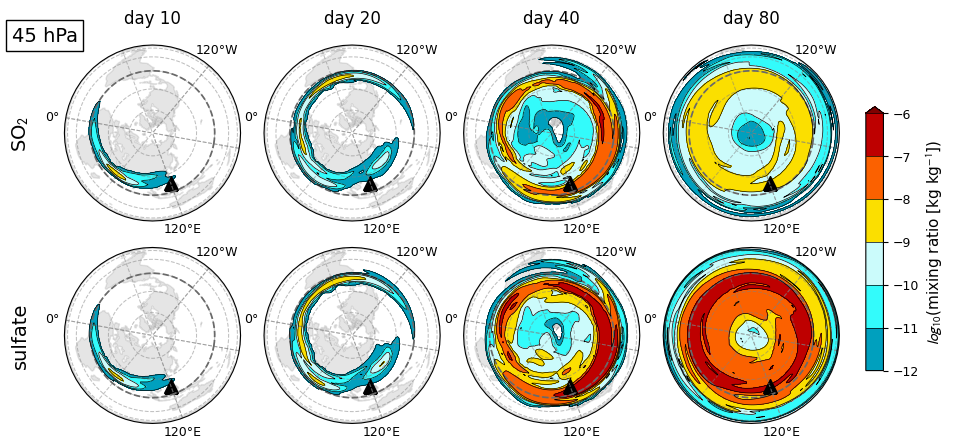

In [7]:
# ==================================
# =============== plot =============

erupt_time = 180
times = np.array([10, 20, 40, 80]) + erupt_time

sizef = 1
fig = plt.figure(figsize=(10*sizef,6*sizef))
gs  = GridSpec(2, len(times), wspace=0.133, hspace=-0.22)

lat0, lon0 = 15.15, 120.35
lon_center = 0
dlat = 1
clipc = -15
minc = -12
maxc = -6
clevels = abs(minc - maxc) + 1

levels = np.linspace(minc, maxc, clevels)
cmap   = au.GMT_no_green
cmap = au.nrl_sirkes

data_crs = ccrs.PlateCarree()
projection = ccrs.LambertAzimuthalEqualArea(central_longitude=100, central_latitude=90)

for i in range(2):
    for j in range(len(times)):
        
        idx = i*(len(times)) + j
        plev = float(tracers[i].lev.values)

        print('plotting tracer {} at time {} on axes {}'.format(tracers[i].name, times[j], idx))
        tracer, lon_ = cutil.add_cyclic_point(tracers[i].sel(time=times[j]), lon)
        tracer = tracer.data
        LON, LAT = np.meshgrid(lon_, lat)

        # ---- horz slice: replace zeros with tiny value, for log ----
        mask = np.logical_or(tracer == 0, tracer < 10**clipc)
        tracer = np.ma.masked_array(tracer, mask).filled(10**clipc) 
        tracer = np.log10(tracer)

        # ---- plot variable ---- 
        ax = fig.add_subplot(gs[idx], projection=projection)
        img = ax.contourf(LON, LAT, tracer, levels=levels, cmap=cmap, extend='max', transform=data_crs)
        ax.contour(LON, LAT, tracer, levels=levels, colors='k', 
                   linestyles=['-'], linewidths=[0.5], zorder=99, transform=data_crs)

        # ---- plot injection ----
        ax.plot([120], [15], '^k', ms=10, transform=data_crs)

        # ---- make gridlines ----
        ax.set_global()
        gl = ax.gridlines(crs=data_crs, draw_labels=False, linewidth=0.75, 
                          color='grey', alpha=0.5, linestyle='--')
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 30))

        gl2 = ax.gridlines(crs=data_crs, draw_labels=False, linewidth=1.25, 
                           color='dimgrey', alpha=1, linestyle='--')
        gl2.ylocator = mticker.FixedLocator([0])
        gl2.xlocator = mticker.FixedLocator([])

        gl3 = ax.gridlines(crs=data_crs, draw_labels=True, linewidth=0.75, 
                           color='grey', alpha=0.5, linestyle='--')
        gl3.xlabel_style = {'size': SMALL_SIZE}
        gl3.ylocator = mticker.FixedLocator([])
        gl3.xlocator = mticker.FixedLocator([0, 120, -120])

        # ---- format figure ----
        #ax.coastlines(linewidth=0.5, alpha=0.75)

        land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                    edgecolor='grey', facecolor='grey', alpha=0.2, zorder=0)
        ax.add_feature(land_feature)

        # ---- add colorbar -----
        if(j == len(times)-1 and i == 0):
            axins = inset_axes(ax,
                       width="10%",
                       height="150%",
                       loc='upper left',
                       bbox_to_anchor=(1.15, -0.35, 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0)
            cbar = fig.colorbar(img, cax=axins, orientation='vertical', pad=0, extendfrac=0.025)
            cbar.set_label(r'$\mathit{log}_{10}$(mixing ratio [kg kg$^{-1}$])')
            cbar_levels = np.linspace(levels.min(), levels.max(), len(levels) * 2 + 1)
            for k in range(len(levels)):
                axins.axhline(levels[k], color='k', lw=0.5)

        # ---- add pressure level, day, and tracer labels ----
        if(i == 0 and j == 0):
            props = dict(facecolor='white', alpha=1)
            txt =ax.text(-0.3, 1, '{:.0f} hPa'.format(np.floor(plev)), transform=ax.transAxes, fontsize=BIGGER_SIZE,
                         va='bottom', ha='left', bbox=props, alpha=1, zorder=99)
        if(i == 0):
            txt =ax.text(0.5, 1.1, r'day {}'.format(times[j]-erupt_time), transform=ax.transAxes, fontsize=BIG_SIZE,
                         va='bottom', ha='center', alpha=1, zorder=99)
        
        if(j == 0):
            tracer_name = [r'SO$_2$', r'sulfate']
            txt =ax.text(-0.25, 0.5, tracer_name[i], rotation=90, transform=ax.transAxes, fontsize=BIGGER_SIZE,
                         va='center', ha='center', alpha=1, zorder=99)
            bbox = txt.get_bbox_patch()
            

plt.savefig('figs/plume_transport.pdf', dpi=300, bbox_inches='tight')
plt.show()